In [ ]:
import os
import re
import warnings
import folium
import pickle
import gensim
import math
import numpy as np
import pyLDAvis.gensim
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels as sm
import seaborn as sns 
import colorlover as cl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import scipy.stats as stats 
import plotly.io as pio
import plotly.offline as py
import xgboost as xgb


from os import path
from PIL import Image
from gensim import corpora
from empath import Empath
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from scipy.stats import powerlaw 
from folium import plugins
from folium.plugins import HeatMap
from IPython.display import IFrame
from plotly import graph_objects as go


from scipy import stats
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
 

from violation_preprocessing import violation_separator, violations_dataframe
from mapping_functions import generateBaseMap, geodataframe, chlorepleth_map, adding_Marker, adding_CircleMarker
from ml_functions import GBT_classification, Rf_classification, plot_confusion_matrix

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')
pio.renderers.default = 'iframe'

# 1- Contextualization 

In order to add a context to our data story, we decided to introduce a new dataset : [US National Outbreak](https://wwwn.cdc.gov/norsdashboard/)

In [ ]:
# import the new dataset
data_outbreak_0 = pd.read_excel('data/NationalOutbreakPublicDataTool.xlsx')

# selection of column of interest
interest_columns = ['Year','State','Etiology','Setting','Illnesses','Hospitalizations','Food Vehicle','Food Contaminated Ingredient']

# dataframe of interest
data_outbreak = data_outbreak_0[interest_columns]

data_outbreak.head(3)

## 1.1 US outbreak mapping 

The aim of this part is to plot the number of outbreaks per state. 

In [ ]:
# counting the number of outbreak per state 
data_outbreak_count = pd.DataFrame(data_outbreak.groupby('State').count())

data_outbreak_count.reset_index(inplace = True)

# selecting only the column of interest for the mapping
data_outbreak_count = data_outbreak_count[['State','Year']]

data_outbreak_count.rename(columns = {'Year': 'count','State':'name'}, inplace = True)

data_outbreak_count.head(3)

> we need to use a geojson file for the border of each nation.

In [ ]:
# path to geoJson file 
us_geo = os.path.join('data/us-states.json')

# creation of a geodataframe using geopandas
us_gdf = gpd.read_file(us_geo)

# add a column with the x-coordinate of the multipolygon
us_gdf['centroid_y'] = us_gdf['geometry'].centroid.x

# add a column with the y-coordinate of the multipolygon
us_gdf['centroid_x'] = us_gdf['geometry'].centroid.y

# setting a projection  by assigning the WGS84 latitude-longitude CRS to the crs attribute
us_gdf.crs = {'init' :'epsg:4326'}

# merging the geodataframe with our data of interst
us_outbreak_gdf = pd.merge(us_gdf,data_outbreak_count, on = 'name')

us_outbreak_gdf.head(3)

> In the part below, we will not use the class created for mapping to use more specific parameters.

In [ ]:
# creating a basic map of Chicago
map_ = folium.Map(location = [us_gdf.centroid_x.mean(),us_gdf.centroid_y.mean()], control_scale = True, zoom_start = 4)

# cleaning the map background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(map_)

# setting our scale for the map colors 
myscale = list([0,500,1000,2000,3000])

folium.Choropleth(
        geo_data = us_geo,
        name = 'US Outbreak',
        data = us_outbreak_gdf,
        columns = ['id','count'],
        key_on = 'feature.id',
        fill_color = 'Blues',
        fill_opacity = 0.8,
        line_opacity = 1,
        legend_name = 'Outbreaks numbers',
        threshold_scale = myscale,
        smooth_factor = 0
        
    ).add_to(map_)



style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}


L = folium.features.GeoJson(
    us_outbreak_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['name','count'],
        aliases = ['State : ','Number of outbreak :'],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)

folium.Marker(
        location = [41.8600, -87.6298], # coordinates for the marker 
        popup = 'CHICAGO ' ,  # pop-up label for the marker
        icon = folium.Icon(color = 'darkred', icon ='arrow-down')
    ).add_to(map_)


map_.add_child(L)
map_.keep_in_front(L)
folium.LayerControl().add_to(map_)

**Link to the map** : [Us Outbreak map](docs/maps/US_map.html)

## 1.2 Food causing poisoning pie chart

The aim of this part is to find out which type of food cause the highest cases of foodorne illnesses.

In [ ]:
# selection of column of interest
interest_columns = ['Etiology','Illnesses','Hospitalizations','Food Vehicle','Food Contaminated Ingredient']

# creating a new dataset with food
data_food = data_outbreak_0[interest_columns]

# removing all the unknown values
data_food = data_food.dropna()

data_food.head(3)

> We need to clean the Food Vehicle column.

In [ ]:
# split then explode 
data_food['Food Vehicle'] = data_food['Food Vehicle'].str.split()
data_food = data_food.explode('Food Vehicle')

# cleaning the food column
data_food['Food Vehicle'] = data_food['Food Vehicle'].str.replace('[^\w\s]','')

ignore = ['unspecified','bbq','other','and','unpasteurized','gravy','ground','raw']

# delete the unwanted words
data_food = data_food[~data_food['Food Vehicle'].str.contains('|'.join(ignore))]

total_food = data_food['Food Vehicle'].nunique()

total_illnesses = data_food['Illnesses'].sum()

print('There is ', total_food ,' different ingredients that can cause a foodborn illness.')

data_food.head(3)

In [ ]:
# create a dataframe grouped by food vehicle
grouped_df = pd.DataFrame(data_food.groupby('Food Vehicle').first())

# sum the number illnesses cases per type of food
ill_df = pd.DataFrame(data_food.groupby('Food Vehicle')['Illnesses'].sum())

ill_df.reset_index(inplace = True)

# merge our dataframe or interest
merged = pd.merge(grouped_df,ill_df, on = 'Food Vehicle')

merged.rename(columns = {'Illnesses_y': 'illnesses_cases'}, inplace = True)

# percentage computation for the pie chart 
merged['percentage'] = round((merged['illnesses_cases']/total_illnesses)*100,2)

# sort by percentage
merged = merged.sort_values('percentage', ascending = False)

merged.head(3)

> In this part we will just clean the data to obtain a readable plot.

In [ ]:
# keep only the relatively high percentage
merged_plot = merged[merged['percentage'] > 1.25]

# creation of the 'other' categorie for the pie chart
other = merged[merged['percentage'] <= 1.25]

# total percentage computation for the 'other' food category
other_percentage = other.percentage.sum()

# adding the 'other' percentage to the data for the plot
merged_plot.loc[0] = ['others', 'many', 'NAN','NAN','NAN','NAN',other_percentage]

# data used for the plots 
merged_plot.head(5)

In [ ]:
# plotting of pie chart

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Pie(
                    labels = merged_plot['Food Vehicle'],
                    values = merged_plot['percentage'],
                    visible = True,
                    marker_colors = cl.scales['10']['div']['RdBu']
                )
             )

fig.layout.update(
    autosize = False,
    width = 400,
    height = 400,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Foods and their percentage of outbreaks',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    )
)

fig.show()

# 2- Spatial visualisation 

The aim of this part is to have a spatial visualisation of the inspections features. The map that we will create below will be used in different part of the data story. 
As each zip code have a different number of facilities, we will normalize each feature as follow :
> proportion = # of facilities with feature(i) / # total number of facilities per zip code

In [ ]:
# import the cleaning dataset (main project dataset) 
data = pd.read_csv('data/clean_dataset.csv', delimiter = ',')

# drop the unnamed column
data.drop(['Unnamed: 0'], axis = 1,inplace = True)

# convert the zip column into an str
data.zip = data.zip.astype(str)
    
# reformat the zip code writing in order to compare it with the zip code in geojson file (for vizualisation step)
data['zip'] = data['zip'].apply(lambda x : x.split('.')[0])

# we just want to extract the level of risk ( 1 , 2 or 3)
data['risk'] = data['risk'].astype(str) 
data['risk_level'] = data['risk'].str[5]
data['risk_level'] = data['risk_level'].astype(float)

# show the dataframe
display(data.head(3))

In [ ]:
# creating our geodataframe based on the basic dataframe
gdf = geodataframe(data)
gdf.head(3)

## 2.1 Food facilities repartition in chicago

In [ ]:
#create a dataset with unique facilities
data_unique = data.drop_duplicates(subset = 'license')

In [ ]:
#plotting the clustered map 

map_clustered = generateBaseMap()
cluster = folium.plugins.MarkerCluster(name = "cluster name").add_to(map_clustered)
for i in range(len(data_unique)):
    folium.Marker(
        location = [data_unique.latitude.values[i],data_unique.longitude.values[i]], # coordinates for the marker 
        popup = data_unique.zip.values[i] ,  # pop-up label for the marker
        icon = folium.Icon(color = 'darkpurple')
    ).add_to(cluster)
    
#map_clustered.save('maps/cluster_map.html')

**Link to the map** : [Facilities spatial repartition](docs/maps/cluster_map.html)

## 2.2 Proportion of failed inspection per zip area

> In this partt, we will focus on the facilities that failed their inspections

In [ ]:
# creating a dataset with only the fail results 
fail_data = data[~data['results'].isin(['Pass','Pass w/ Conditions'])]

# counting the number of fail per zip code
fail_count_per_zip = pd.DataFrame(fail_data.groupby('zip')['results'].count()).reset_index()
fail_count_per_zip.rename(columns = {'results': 'fail_count'}, inplace = True)

# merge with gdf dataframe and facility count dataframe 
fail_gdf = pd.merge(gdf,fail_count_per_zip, on = 'zip')

# proportion of facility that failed the investigation per zip code
fail_gdf['fail_proportion'] = round(fail_gdf['fail_count'].divide(fail_gdf['facility_number_per_zip'])*100,2)

fail_gdf.head(3)

In [ ]:
fail_map = chlorepleth_map('Fail proportion',fail_gdf,['zip','fail_proportion'],'Fail proportion','Reds')

# add transparent background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(fail_map)

#adding an interactif option to have informations about each zip code
FIL = folium.features.GeoJson(
    fail_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['zip','facility_number_per_zip','fail_proportion'],
        aliases = ['Zip: ','Number of inspections','% of failed inspections: '],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
fail_map.add_child(FIL)
fail_map.keep_in_front(FIL)
folium.LayerControl().add_to(fail_map)

#fail_map.save('maps/interactif_fail_map.html')

IFrame(src = 'maps/interactif_fail_map.html', width = 700, height = 600)

**Link to the map** : [Failed inspections map](docs/maps/interactif_fail_map.html)

## 2.3 Proportion of facilities associated with high risk level

In [ ]:
risk_per_zip = data[['zip','risk_level']]
risk_per_zip = data[data['risk_level'] == 1.0 ]

# calculating the number of facilities per zip for the normalization 
data_zip = pd.DataFrame(data.groupby('zip')['inspection_id'].count())
data_zip.rename(columns = {'inspection_id': 'total_count'}, inplace = True)
data_zip.reset_index()

# counting the number of facilities per zip code where the risk is high
risk_per_zip = pd.DataFrame(risk_per_zip.groupby('zip')['inspection_id'].count())
risk_per_zip = risk_per_zip.reset_index()

risk_per_zip.rename(columns = {'inspection_id': 'high_risk_count'}, inplace = True)

risk_per_zip = pd.merge(risk_per_zip,data_zip, on ='zip')

risk_per_zip['percentage'] = risk_per_zip['high_risk_count'].divide(risk_per_zip['total_count'])*100

risk_per_zip.head(3)

In [ ]:
#Map showing the repartition of average risk level in chicago per zip code

# creating our geodataframe based on the basic dataframe
gdf = geodataframe(data)
gdf.head(3)
    
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}


# merge with gdf dataframe  
risk_gdf = pd.merge(gdf,risk_per_zip, on = 'zip')

risk_map = chlorepleth_map ('Risk proportion',risk_gdf,['zip','percentage'],'Average Risk Level','YlOrRd')

# add transparent background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(risk_map)

RIL = folium.features.GeoJson(
    risk_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['zip','percentage'],
        aliases = ['Zip: ','Proportion of facilities associated with high risk :'],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
risk_map.add_child(RIL)
risk_map.keep_in_front(RIL)
folium.LayerControl().add_to(risk_map)

#risk_map.save('maps/interactif_risk_map.html')
IFrame(src = 'maps/interactif_risk_map.html', width = 700, height = 600)

**Link to the map** : [High risk level map](docs/maps/interactif_risk_map.html)

# 3- Relationships investigation

The aim of this part is to investigate if there is a correlation between inspections due to food poisoning and inspections' elements as the risk level of a facility or the reported inspections.

In [ ]:
# data set with only inspection due to suspected food poisoning
poisoning_data = data[data['inspection_type'] == 'Suspected Food Poisoning']

## 3.1 Inspection failure and food poisoning

In [ ]:
# counting the number of failed/ pass / pass with conditions within the poisoning cases
results_count = list(poisoning_data.groupby('results')['inspection_id'].count())

#percentage computation
total = len(poisoning_data)
percentage = [ (a/total)*100 for a in results_count]

#poisoning_data.groupby('results').count()

In [ ]:
# bar plotting

bars = ['Fail','Pass','Pass w/ Conditions ']

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Bar(
                    x = bars,
                    y = percentage,
                    visible = True,
                    marker_color='maroon'
                    
                )
             )

fig.layout.update(
    autosize = False,
    width = 400,
    height = 400,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Inspections due to suspected food poisoning',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Percentage %',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Inspection results',
        titlefont_size = 14
    )
)

fig.show()

 **Link to the map** : [Inspections result for food poisoning ](plots/inspect_result_fp.html)

## 3.2 Risk level and food poisoning

In [ ]:
# counting the total number of facilities (poisoning inspections) associated with a particular risk level
risk_level_count = list(poisoning_data.groupby('risk_level')['inspection_id'].count())

# percentage computation
total = len(poisoning_data)
percentage = [ (a/total)*100 for a in risk_level_count]

In [ ]:
# plotting of bar plot

bars = ['High','Medium','Low']

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Bar(
                    x = bars,
                    y = percentage,
                    visible = True,
                    marker_color='maroon'
                    
                )
             )

fig.layout.update(
    autosize = False,
    width = 400,
    height = 400,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Risk level ass. w/ suspected food poisoning',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Percentage %',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Risk level',
        titlefont_size = 14
    )
)

fig.show()

**Link to the plot** : [Risk Level for food poisoning facilities](risk_suspected_fp.html)

> In the following part , we will try to see if there is a relationship between the food poisoning and the risk level within a zip code

In [ ]:
# counting the number of facilities per zip 
facility_number_per_zip = pd.DataFrame(data.groupby('zip')['license'].count()).reset_index()


pois_facility_number_per_zip = pd.DataFrame(poisoning_data.groupby('zip')['license'].count()).reset_index()

# merge in order to calculate the proportion
number_facilities_df = pd.merge(facility_number_per_zip, pois_facility_number_per_zip, on ='zip')
number_facilities_df.rename(columns = {'license_x': 'total number', 'license_y':'poisoning number'}, inplace = True)

# frequency of inspection due to food poisoning in a given zip
number_facilities_df['frequency(%)'] = number_facilities_df['poisoning number'].divide(number_facilities_df['total number'])*100

In [ ]:
# merge with the frequency dataset without central fusion 
risk_correlation = pd.merge(number_facilities_df,risk_per_zip, on = 'zip')

risk_correlation .head(3)

In [ ]:
# plotting of bar plot

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Scatter(
    x = risk_correlation['percentage'],
    y = risk_correlation['frequency(%)'],
    visible = True,
    marker_color='maroon',
    mode = 'markers',
    text = risk_correlation['zip']
                )
             )

# adding trace for website
fig.add_trace(go.Scatter(
    x = [43.8, 45.8, 45.8, 43.8, 43.8],
    y = [1.18, 1.18, 1.11, 1.11, 1.18],
    mode = "lines",
    line = go.scatter.Line(color = "red"),
    showlegend = False))

fig.layout.update(
    autosize = False,
    width = 700,
    height = 700,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Poisoning inspections and facilities associated with high risk',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Percentage of facilities inspected for food poisoning',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Percentage of high risk facilities per zip code',
        titlefont_size = 14
    ),
    showlegend = False
)

fig.show()

**Link to the plot** : [Relationship between risk level and poisoning](cluster_plot.html)

In [ ]:
# explain outlier

In [ ]:
# we remove 'outliers'
outliers = ['60827','60656','60611']

risk_correlation_without_outliers = risk_correlation.query('zip != @outliers')

# spearman coeff 
print('The spearman coefficient is : ',stats.spearmanr(risk_correlation_without_outliers['percentage'],risk_correlation_without_outliers['frequency(%)']))


In [ ]:
#add comment

## 3.3 Violation type and food poisoning

In [ ]:
#introduire le buble plot de jasmine 

# 4-Sea Exploration 

In [ ]:
#introduire une description 

## 4- Visual exploration 

In [ ]:
# counting the number of fail per zip code
poisoning_count_per_zip = pd.DataFrame(poisoning_data.groupby('zip')['results'].count()).reset_index()
poisoning_count_per_zip.rename(columns = {'results': 'poisoning_count'}, inplace = True)

# merge with gdf dataframe and facility count dataframe 
poisoning_gdf = pd.merge(gdf,poisoning_count_per_zip, on = 'zip')

# proportion of facility that passed the investigation per zip code
poisoning_gdf['poisoning_proportion'] = round((poisoning_gdf['poisoning_count'].divide(poisoning_gdf['facility_number_per_zip']))*100,2)
poisoning_gdf.head(3)

In [ ]:
poisoning_map = chlorepleth_map ('Poisoning proportion', poisoning_gdf, ['zip','poisoning_proportion'], 'Suspected poisoning proportion', 'PuRd')

# for plotting without e-coli
poisoning_map_reserve = poisoning_map

# add transparent background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(poisoning_map)

### Introduction of the e-coli dataset

In [ ]:
ecoli_df = pd.read_csv('data/beach-e.-coli-predictions.csv', delimiter = ',')

# we keep only the predicted values that are above the BAV limi (cf milestone 2)
data_filtered = ecoli_df[ecoli_df['Predicted Level'] > 235]

high_ecoli_concentration = pd.DataFrame(data_filtered.groupby('Beach Name')['Predicted Level'].count())
high_ecoli_concentration.reset_index(inplace = True)

high_ecoli_concentration.head(3)

In [ ]:
# merging the data_filtered dataframe with the high_ecoli_concentration dataframe to have beaches' location
high_ecoli_concentration_location = pd.merge(data_filtered,high_ecoli_concentration,on = 'Beach Name', how = 'inner')

# groupby beaches and creating a dataframe
high_ecoli_concentration_location = high_ecoli_concentration_location.groupby('Beach Name').first()

high_ecoli_concentration_location = pd.DataFrame(high_ecoli_concentration_location)
high_ecoli_concentration_location.rename(columns = {'Predicted Level_y': 'High measure count'}, inplace = True)
high_ecoli_concentration_location.reset_index(inplace = True)
high_ecoli_concentration_location.sort_values(by=['High measure count'], ascending = False)

high_ecoli_concentration_location.head(3)

In [ ]:
for i in range(len(high_ecoli_concentration_location)):
    popup = str(high_ecoli_concentration_location['Beach Name'].values[i]) + '\n'+'High measure count :'+ str(high_ecoli_concentration_location['High measure count'].values[i])
    if (high_ecoli_concentration_location['High measure count'].values[i]  < 10):
        colour = 'green'
    if (high_ecoli_concentration_location['High measure count'].values[i] < 30 and high_ecoli_concentration_location['High measure count'].values[i] >10):
        colour = 'orange'
    if (high_ecoli_concentration_location['High measure count'].values[i] >= 30):
        colour = 'red'
    adding_Marker(poisoning_map,high_ecoli_concentration_location.Longitude.values[i], high_ecoli_concentration_location.Latitude.values[i], popup , colour)


PIL = folium.features.GeoJson(
    poisoning_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['zip','facility_number_per_zip','poisoning_count','poisoning_proportion'],
        aliases = ['Zip: ','Total number of inspections','Number of inspection due to suspected food poisoning','Percentage: '],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
poisoning_map.add_child(PIL)
poisoning_map.keep_in_front(PIL)
folium.LayerControl().add_to(poisoning_map)

#poisoning_map.save('maps/interactif_poison_map.html')
IFrame(src = 'maps/interactif_poison_map.html', width = 700, height = 600)

**Link to the map** : [food poisoning and e-coli concentration](interactif_poison_map.html)

## 4.2 Distance by Chicago center and distance by the sea 

Let's import the json file on the zip codes in Chicago:

In [ ]:
import json
# 'Boundaries-ZIPCodes.geojson' taken from the internet
with open('Boundaries-ZIPCodes.geojson') as f:
    # load json file
    zip_info = json.load(f)
# data_zip contains the geometrical information
data_zip = json_normalize(zip_info['features'])
# display dataframe
data_zip.head()

The geometry.coordinates is not accessible in this way. We shall modify it so that it becomes a list of coordonates. 

In [ ]:
# polygons is a list of polygons
polygons = []
for l in range(data_zip.shape[0]):
    # polygon is a list of coordinates
    polygon = []
    # taking all the coordinates for a polygon
    for i in range(len(data_zip['geometry.coordinates'][l][0][0])):
        # add the i-th element to the polygon list
        polygon.append(data_zip['geometry.coordinates'][l][0][0][i])
    # adding a polygon to a list of polygons
    polygons.append(polygon)  
# create a new column with the correct writing
data_zip['polygon'] = polygons

Now let's import the dataframe with the violations.

In [ ]:
# importing data
clean_data = pd.read_csv('clean_dataset.csv')

An imaginary line is drawn between the 2 locations by the sea. This line will represente the border, so to calculate the distance to the sea, we shall calculate the shortest distance to this line.

In [ ]:
dist_km = []
for i in range (clean_data.shape[0]):
    # first location by the sea
    x1 = (41.963779, -87.632323)
    # second location by the sea
    x2 = (41.894318, -87.605099)
    # latitude from dataframe
    lat = clean_data.latitude.values[i]
    # longitude from dataframe
    lon = clean_data.longitude.values[i]
    # coordinate
    p = (lat, lon)
    # point
    point = Point(p)
    # creation of the line
    line = LineString([Point(x1), Point(x2)])
    # add distance from point to line * 111, because 1 degree = 111 km 
    dist_km.append(point.distance(line)*111)
    # print values
    print('point:',p,', distance :',dist_km[-1])
# add column to dataframe
clean_data['distance_to_sea'] = dist_km

Plots and Correlations: We will plot the correlations of the distance to the sea and to the city center for each zip with respect to the food poisoning.

In [ ]:
# taking only 2 columns
Dist_to_sea = clean_data[['zip','distance_to_sea']]
# averaging the distance to the sea for each zip
Dist_to_sea = Dist_to_sea.groupby(Dist_to_sea.zip).mean()
# reset index
Dist_to_sea= Dist_to_sea.reset_index()
# exporting to csv
Dist_to_sea.to_csv('Distance_sea_zip.csv')
# dataframe with food poisoning per zip code
prop = pd.read_csv('proportion.csv')
# conversion to int to enable merging
Dist_to_sea['zip'] = Dist_to_sea['zip'].astype(int)
# merging of distance to sea and food poisoning
DF_merge = pd.merge(Dist_to_sea, prop, on='zip', how='outer')

In [ ]:
# importing mean distance to city center of each zip
center = pd.read_csv('center_distance_df.csv')
# dropping first value
center= center.drop(0)
# changing zip type to int
center['zip']=center['zip'].astype(int)
# merging food poisoning with distance to center
DF_center = pd.merge(prop, center, on='zip', how='outer')
# drop NaN values
DF_center= DF_center.dropna()
# merging distance to center with DF_merge
DF =  pd.merge(center,DF_merge, on='zip', how='outer')
# drop NaN values
DF_merge.dropna(inplace = True)

In [ ]:
fig = go.Figure()


# set up the first trace
fig.add_trace(go.Scatter(
    x = DF_merge['distance_to_sea'],
    y = DF_merge['pois_total'],
    visible = True,
    marker_color='blue',
    mode = 'markers',
    text =DF_merge['zip']
                )
             )
fig.add_trace(go.Scatter(
    x = DF_center['mean_distance'],
    y = DF_center['pois_total'],
    visible = True,
    marker_color='red',
    mode = 'markers',
    text =DF_center['zip']))



fig.layout.update(
    autosize = False,
    width = 700,
    height = 700,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Poisoning inspections with respect to the distance to sea / city center',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Number of facilities causing food poisoning',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Distance to sea (blue) /city center (red)',
        titlefont_size = 14
    ),
    showlegend = False
)
#fig.savefig('distance_sea_centre.png')
fig.show()

An outlier can be seen for values over 70. 

In [ ]:
# plotting linear regression
fig = plt.figure(figsize=(10,7))
sns.regplot(x = DF.distance_to_sea, y = DF.pois_total, color = 'blue', marker = '+')
sns.regplot(x = DF.mean_distance, y = DF.pois_total, color = 'red', marker = '+')
plt.title('Relationship between Percentage of Food Poisoning and Distance to sea (blue)/ Center (red)', size = 24)
plt.legend(labels = ['Distance to Sea','Distance to Center'])

In [ ]:
# correlation
DF.corr().pois_total

We shall compare the correlations by using two methods : pearson and spearman

Spearman: 

In [ ]:
# correlation and p-values
len_ = DF_merge.shape[0]
print('The spearman coefficient is : ',stats.spearmanr
      (DF_merge['distance_to_sea'],DF_merge['pois_total']),'n=',len_)
print('The spearman coefficient is : ',stats.spearmanr
      (DF_center['mean_distance'],DF_center['pois_total']),'n=',len_)

Pearson:

In [ ]:
# Pearson correlation coefficient and p-value for distance to sea
pearson_coef, p_value = stats.pearsonr(DF_merge.distance_to_sea, DF_merge.pois_total)
print(pearson_coef)

# Pearson correlation coefficient and p-value for distance to city center
pearson_coef, p_value = stats.pearsonr(DF_center.mean_distance, DF_center.pois_total)
print(pearson_coef)

The distance to the sea seems to have a slighty better correlation with the food poisoning. 

## 4.3 Investigation about e-coli

# 5- Natural Langage processing of post from iwaspoisonned.com

In [ ]:
#add a description

Violations Text Handling

The complaints written on the website Iwaspoisoned.com are analysed so that we can know what kinds of food cause sicknesses and in which zip codes.

Finding the important words per zip

In [ ]:
nlp = spacy.load('en')

This function will retrieve all the words that are useful for topic detection. Stopwords are taken out and lemmatization is used.

In [ ]:
def get_all_words_from_text (text_):
    TEXT = []
    # create document with input text
    doc = nlp(text_)
    token_without_stop_lemma = []
    # add all words after "lemmatization conversion"
    for token in doc:
        token_without_stop_lemma.append(token.lemma_)
    # the words are now in a list so we join them again into a text
    new_text = ' '.join(word for word in token_without_stop_lemma)
    # recreation of a doc
    doc2 = nlp(new_text)
    # taking out stopwords and punctuation
    words = [token.text for token in doc2 if token.is_stop != True and token.is_punct != True]
    # return list of words
    return words

Finding Topics: This function will be handy to pick some topics from the text.

In [ ]:
def Topic(df,NUM_TOPICS = 4, num_words_ = 2):

    dictionary = corpora.Dictionary(df.new_list_of_words.values.tolist())
    corpus = [dictionary.doc2bow(text) for text in df.new_list_of_words.values.tolist()]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes = 15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words= num_words_)
    for topic in topics:
        print(topic)

Webscraping Text Handling 

Let's import the csv file from the webscraping of the iwaspoisoned website.

In [ ]:
# import the cleaning dataset 
data_web = pd.read_csv('Food_Poisoning3.csv', delimiter = ',')
# taking only the zip and comments columns
data_web = data_web[['Zip','Comments']]

In comments, we have a text in each row of the report made by a person on food poisoning.

In [ ]:
# drop any nan values
data_web.dropna(inplace = True)
# change zip type to int
data_web['Zip'] = data_web['Zip'].astype(int)
# changing the type of zip to int
data_web['Zip'] = list(map(lambda x : int(x) if (math.isnan(x) == False) else np.nan, data_web.Zip.values.tolist()))
# lowercasing everything
data_web['Comments'] = data_web['Comments'].str.lower()


If "inspection failure" is in the comments, then it is not a complaint from a person but a description of an inspection failure. We are only interested in analyzing texts written by people.

In [ ]:
# data with "inspection failure" in comments
df_inspection_failures = data_web[data_web['Comments'].str.contains("inspection failure")]
# all rows except the "inspection failures"
df_complaints = data_web[~data_web.isin(df_inspection_failures)].dropna()

This dataframe contains all the comments made by people on the website along 

In [ ]:
df_complaints.head()

Some words that aren't stop words do not give insight on the topic but occur many times. We shall discard some of them.

In [ ]:
def New_List_Words(data_web):
    list_ = []
    # for each row in the dataframe
    for i in range(data_web.shape[0]):
        # append the only useful words from the text in a list
        list_.append(get_all_words_from_text(data_web.Comments.values[i]))
    # creating a new column with this list
    data_web_words = {'zip': data_web.Zip.values.tolist(), 'list_of_words':list_} 
    # Create DataFrame 
    df = pd.DataFrame(data_web_words) 
    # useless words in a list
    useless_words= ['inspection','failure','observe','-PRON-','"','issue','instruct','be','premise','have','find','detail','item','area','note','unit','do','start','not','run','get',"  ",'go','continue','take','continue','ask','say',' ','>','   ','\r\n ','30','8']
    # list of words from the dataframe
    test_list = df.list_of_words.values.tolist()
    # all words in a list of each row
    for w in useless_words:
        # if it isn't a useless word, keep it
        res = [[ele for ele in sub if ele != w] for sub in test_list] 
        test_list = res
    # creating a new column
    df['new_list_of_words'] = test_list
    return df

In [ ]:
# applying the function to complaints
df_complaints_ = New_List_Words(df_complaints)
df_complaints_.head()

Let's try and define some topics:

In [ ]:
Topic(df_complaints_,5, 2)

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))

lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

Lexicon :
Lexicon gives us categories of subjects that include lists of related words. We could use this to identify words from a certain topic. For example, we could identify all food related words to identify which types of food have been causing food poisoning. Also, we will investigate on the medical related terms to know more about the symptoms.

In [ ]:
lexicon = Empath()

We will now take count the occurences of words in the reports.

In [ ]:
from functools import reduce
list_text = []
# join all words from the lists to create a text
for sentence in df_complaints_.new_list_of_words:
    list_text.append(' '.join(sentence))
text = ' '.join(list_text)
# count frequencies of each word
freq = reduce( lambda d, c: d.update([(c, d.get(c,0)+1)]) or d, text.split(), {})

In [ ]:
def make_freq_graph(text):
    # get data directory (using getcwd() is needed to support running example in generated IPython notebook)
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

    # read the mask image
    # taken from
    # https://www.canstockphoto.com/chicago-city-map-63451119.html
    chicago_image = np.array(Image.open(path.join(d, "istockphoto-908943762-1024x1024.png")))

    # word cloud
    wc = WordCloud(
        background_color="white", 
        max_words=2000, 
        mask= chicago_image,
        contour_width=3, 
        contour_color='steelblue'
    )
    
    # generate word cloud
    wc.generate(text)


    # show
    fig = plt.figure()
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    plt.imshow(chicago_image, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()


In [ ]:
# display image
image_array = make_freq_graph(text)

The bigger the word, the more frequent it is in the reports of food poisoning 

Plotting word frequencies per topic and geography

Plotting most frequent words per zip : Let's create a dataframe with all words occurences for each zip code.

In [ ]:
DF_complaints = df_complaints_.groupby('zip').agg(sum)
DF_complaints.reset_index(inplace = True)
del DF_complaints['list_of_words']
# creation of the dataframce
rows = []
_ = DF_complaints.apply(lambda row: [rows.append([row['zip'], nn]) 
                         for nn in row.new_list_of_words], axis = 1)
df_new = pd.DataFrame(rows, columns = DF_complaints.columns).set_index(['zip'])

In [ ]:
df_new.head()

In [ ]:
# reset index
df_new.reset_index(inplace = True)
# counting occurences
df_new = df_new.groupby(df_new.columns.tolist()).size().\
    rename(columns={0:'records'})
# reset index
df_new = df_new.reset_index()
# defining columns
df_new.columns = ['zip', 'words','counts']

# joining all words in the list from column 'new_list_of_words'
Text = []
for i in range(df_complaints_.shape[0]):
    Text.append( ' '.join(df_complaints_.new_list_of_words.values[i]))
# create new column
df_complaints_['text'] = Text

df_complaints_.head()

In [ ]:
# join all texts
Text = ' '.join(df_complaints_.text.values)
split_it = Text.split() 
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(50) 

In [ ]:
# only take the word and not it's frequency
most_occur_words = [x[0] for x in most_occur] 

In [ ]:
# dataframe with only the 50 most occuring words
df_new2 = df_new.loc[df_new.words.isin(most_occur_words) ]
sns.set(style = "white")
# Plot
sns.relplot(
    x = "zip", 
    y = "words", 
    size = "counts",
    sizes = (4, 1000), 
    alpha = .5, 
    palette = "muted",
    height = 10, 
    data = df_new2
)

This plot gives us the 50 most frequent words and their occurences per zip code. 

Words in a certain category per distance to the sea : 
The proximity to the sea has been proven to be correlated with the food poisoning due to Ecoli infections. We will see which terms appear with respect to the distance to the sea of the concerned facility.

The categories of interest are :
    - Medical Emergencies
    - Types of Food

In [ ]:
# new list
Medical_Emergency = []
for w in df_new.words:
    # if a word is in the categories related to health
    if (w in lexicon.cats['medical_emergency'])or(w in lexicon.cats['health'])or(w in lexicon.cats['suffering'])or(w in lexicon.cats['pain']):
        # add to list
        Medical_Emergency.append(w)
# drop duplicates
Medical_Emergency = list(dict.fromkeys(Medical_Emergency))

Food = []
for w in df_new.words:
    # if the word is in a category related to food
    if (w in lexicon.cats['cooking']) or (w in lexicon.cats['eating']):
        # add to list
        Food.append(w)
# drop duplicates
Food = list(dict.fromkeys(Food))

In [ ]:
# import distance to sea csv file
dist_sea_zip = pd.read_csv('Distance_sea_zip.csv')

In [ ]:
def relplot_df(df):
    fig = plt.figure()
    sns.set(style="white")
    # plotting
    sns_plot = sns.relplot(x="distance_to_sea", y="words", size="counts",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)
    #sns_plot.savefig("food.png")

Medical Emergency plot:

In [ ]:
# find words that are in the list of medical emergency terms
df_emergency = df_new.loc[df_new.words.isin(Medical_Emergency) ]
# merge with distance to sea
df_emergency = pd.merge(df_emergency, dist_sea_zip, on='zip', how='outer')
# drop nan
df_emergency = df_emergency.dropna()
# round the distance to sea
df_emergency['distance_to_sea']= round(df_emergency['distance_to_sea'])
# plot
relplot_df(df_emergency)
print(' Most frequent health related terms with respect to the distance to the sea')

In [ ]:
# find words that are in the list of food terms
df_food = df_new.loc[df_new.words.isin(Food) ]
# merge with distance to sea
df_food = pd.merge(df_food, dist_sea_zip, on='zip', how='outer')
# drop nan
df_food =df_food.dropna()
# round the distance to sea
df_food['distance_to_sea']= round(df_food['distance_to_sea'])
# plot
relplot_df(df_food)
print(' Most frequent food related terms with respect to the distance to the sea')

These two graphs show that overall, there are more occurences that happen near the sea which implies that food poisoning is most important near the sea (perhaps because of Ecoli). Meat related terms in particular are more frequent near the sea, which confirms our hypothesis on Ecoli infections because they are mainly caused by uncooked meat.

# 6- Applied marching learning 

> In this section, we will train and test a machine learning model that can predict food poisoning cases. This will alert Chicago health care department about these restaurants that might promote the spread of food-borne illness with high risk of poisoning for the population. The features will mainly include: The list of violations committed during an inspection, the location (zip code),  and the risk factor of the restaurant.

## Classification models

> Since the variable that we want to predict is categorical (discrete), we will use a classification method. The classifiers that we select are Random forest and Gradient Boosted Trees.

In [59]:
# labels
class_names = ['No Food Poisoning', 'Food Poisoning']
np.set_printoptions(precision = 4)

## Datasets to be used for training the models

Here, we create all the datasets that will be used to train the future models.

> First, we load the cleaned dataset.

In [ ]:
# opening the data
data = pd.read_csv('data/clean_dataset.csv', delimiter = ',')

# drop the unnamed column
data.drop(['Unnamed: 0'], axis = 1,inplace = True)

# show the dataframe
display(data.head(3))

> Then, we extract the violations numbers from the comments in the 'violations' column, and represent each violation with a binary value for each inspection (violations_dataframe). The other dataset contains weighted minor, critical and serious counts (violations_dataframe02).

**Note**: The two functions below are taken from the class we created: *violation_preprocessing*.

In [ ]:
# We apply this functions to our data 
violation_separated = data.violations.apply(violation_separator).fillna(0)

In [ ]:
#we create our dataframe with all the violations counts
violations_dataframe01, violations_dataframe02 = violations_dataframe(violation_separated,data)

In [3]:
# Export both dataframes to csv files
#violations_dataframe01.to_csv(r'data/violations_binary_representation.csv')
#violations_dataframe02.to_csv(r'data/violations_type_count.csv')

# read from saved csv
violations_dataframe01 = pd.read_csv('data/violations_binary_representation.csv')
violations_dataframe02 = pd.read_csv('data/violations_type_count.csv')

print(print('\n\033[1m Violations per inspection (binary value representation) \033[0m'))
display(violations_dataframe01.head(3))

print(print('\n\033[1m Number of critical ,serious and minor count per inspection \033[0m'))
display(violations_dataframe02.head(3))


 Violations per inspection (binary value representation) 
None


,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2352734,34169.0,Canvass,60666.0,Risk 1 (High),Pass
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2352727,2215815.0,Canvass,60641.0,Risk 1 (High),Pass
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2352738,1801618.0,Canvass Re-Inspection,60605.0,Risk 1 (High),Pass



 Number of critical ,serious and minor count per inspection 
None


,Unnamed: 0,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,...,results,violations,latitude,longitude,location,count,critical_count,serious_count,minor_count,violations_count
0,0,2352734,CHILI'S T-I,CHILI'S (T1-B14),34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-12-04,...,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",1,1.0,0.0,0.0,1.0
1,1,2352727,PORTAGE PARK DAY NURSERY,MOSAIC EARLY CHILDHOOD ACADEMY,2215815.0,Children's Services Facility,Risk 1 (High),5332-5334 W ADDISON ST,60641.0,2019-12-04,...,Pass,0,41.946065,-87.760722,"{'latitude': '-87.76072227616888', 'longitude'...",1,0.0,0.0,0.0,0.0
2,2,2352738,AMARIT RESTAURANT,AMARIT RESTAURANT,1801618.0,Restaurant,Risk 1 (High),600 S DEARBORN ST,60605.0,2019-12-04,...,Pass,0,41.874481,-87.629357,"{'latitude': '-87.62935653990546', 'longitude'...",1,0.0,0.0,0.0,0.0


- **df_New**: In order to be able to train the model effectively, we need to take into consideration the time property of our initial dataset: indeed, each restaurant will face many inspections throughout the years, and the inspections are thus ordered in time. Hence, our model needs to take into account the time property of the dataset. This will be enabled by first ordering the inspections in the dataset (from first to last inspections).

> We will add the inspection date to each of the inspections, recorded with their separate violations, by merging both 'violations_dataframe' (for the separate violations) and 'violations_dataframe02' (for the inspection dates). Since both dataframes contains the inspection_id, which is unique for each inspection, we can merge by 'inspection_id'.

In [4]:
# Extract the date of inspection
df2 = violations_dataframe02[["inspection_id",'inspection_date']]
df2.head(2)

,inspection_id,inspection_date
0,2352734,2019-12-04
1,2352727,2019-12-04


In [5]:
# Merge on inspection_id
df_New = pd.merge(df2, violations_dataframe01, left_index=True, right_index=True, how='outer', on='inspection_id')
df_New.head(2)

,inspection_id,inspection_date,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
0,2352734,2019-12-04,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,34169.0,Canvass,60666.0,Risk 1 (High),Pass
1,2352727,2019-12-04,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2215815.0,Canvass,60641.0,Risk 1 (High),Pass


In [6]:
# Convert into date format
df_New["inspection_date"] = pd.to_datetime(df_New["inspection_date"])

# Sort the inspections by date
df_New = df_New.sort_values(by ="inspection_date",ascending=True)
df_New.head()

,inspection_id,inspection_date,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
134647,104236,2010-01-04,134647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,80916.0,Canvass,60611.0,Risk 1 (High),Fail
134622,134239,2010-01-05,134622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32942.0,Complaint,60647.0,Risk 1 (High),Fail
134621,118296,2010-01-05,134621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,10940.0,Complaint,60608.0,Risk 1 (High),Pass
134620,67759,2010-01-05,134620,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1801271.0,Canvass,60613.0,Risk 1 (High),Pass w/ Conditions
134619,54212,2010-01-05,134619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1992130.0,Complaint,60651.0,Risk 1 (High),Pass


- **data_classified**: Another ordered time series dataset that we can think about and is relevant to use is obtained by grouping the inspections (sorted by time, from the oldest to the most recent ones) by restaurant license (i.e. sorted inspections for each restaurant).

> We group the inspections sorted by time (from the oldest to the newest) by restaurant license.

In [7]:
# create a dataframe with data grouped by license number

dict_resto_1 = {}

for resto, df in df_New.groupby('license'):
  dict_resto_1[resto] = df

data_classified = pd.concat(dict_resto_1.values(), sort = True, ignore_index=True)
data_classified.head()

,#1,#10,#11,#12,#13,#14,#15,#16,#17,#18,...,#8,#9,Unnamed: 0,inspection_date,inspection_id,inspection_type,license,results,risk,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,129254,2010-06-15,229468,Canvass,2.0,Pass,Risk 1 (High),60606.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,121362,2011-02-15,114767,Canvass,2.0,Pass,Risk 1 (High),60606.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,107647,2012-03-19,679663,Canvass,2.0,Pass w/ Conditions,Risk 1 (High),60606.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,107578,2012-03-21,680088,Canvass Re-Inspection,2.0,Pass,Risk 1 (High),60606.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,90539,2013-07-19,1324560,Canvass,2.0,Pass,Risk 1 (High),60606.0


- **df_New_2**: We load the dataset in which we computed a personalized score for each of the inspections. We merge it with the other ones in order to have the list of violations and the inspection date.

In [8]:
# Load the dataset
data_score = pd.read_csv('data/score_violation_df.csv', delimiter = ',')
data_score.head()

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,#37,#38,#39,#40,#41,#42,#43,#44,#70,score
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740464
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.832479
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [9]:
# Extracting the score parameter
df_score = data_score[["score"]]
df_score.head(2)

,score
0,0.000000
1,1.740464


In [10]:
# Violations and score
df_New_2 = pd.merge(df_score, violations_dataframe01, left_index = True, right_index = True, how = 'outer')
df_New_2.head(2)

,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2352734,34169.0,Canvass,60666.0,Risk 1 (High),Pass
1,1.740464,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2352727,2215815.0,Canvass,60641.0,Risk 1 (High),Pass


In [11]:
# Violations, scores and inspection_date
df_New_2 = pd.merge(df2, df_New_2, left_index = True, right_index = True, how = 'outer', on = 'inspection_id')
df_New_2.head(3)

,inspection_id,inspection_date,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
0,2352734,2019-12-04,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,34169.0,Canvass,60666.0,Risk 1 (High),Pass
1,2352727,2019-12-04,1.740464,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2215815.0,Canvass,60641.0,Risk 1 (High),Pass
2,2352738,2019-12-04,2.832479,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1801618.0,Canvass Re-Inspection,60605.0,Risk 1 (High),Pass


In [12]:
# Convert into date format
df_New_2["inspection_date"] = pd.to_datetime(df_New_2["inspection_date"])

# Sort the inspections by date
df_New_2 = df_New_2.sort_values(by = "inspection_date", ascending = True)
df_New_2.head()

,inspection_id,inspection_date,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
134647,104236,2010-01-04,NaN,134647,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,80916.0,Canvass,60611.0,Risk 1 (High),Fail
134622,134239,2010-01-05,NaN,134622,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32942.0,Complaint,60647.0,Risk 1 (High),Fail
134621,118296,2010-01-05,NaN,134621,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,10940.0,Complaint,60608.0,Risk 1 (High),Pass
134620,67759,2010-01-05,NaN,134620,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1801271.0,Canvass,60613.0,Risk 1 (High),Pass w/ Conditions
134619,54212,2010-01-05,NaN,134619,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1992130.0,Complaint,60651.0,Risk 1 (High),Pass


## Encoding the data

Here, we encode our categorical data into numerical values. For the ordinal features (risk factor, result of inspection) we proceeded with an ordinal encoding. We used hot-encoding for the other categorical data (zip code). 

**Encoding of target variable**: Here we create a model to predict the inspections related to food poisoning, i.e. we're only interested in the type of inspection named: 'Suspected Food Poisoning'. We also mapped each value of the inspection type column into a binary value (binary-class): 1 for the food poisoning related, and 0 for all other inspections.

In [13]:
# Encoding the features and the target

# Associate a number to each value of the risk factor
risk_mapper = {'Risk 1 (High)':3,'Risk 2 (Medium)':2,'Risk 3 (Low)':1}

# Associate a number to each value of the results
result_mapper = {'Pass':1,'Pass w/ Conditions':0,'Fail':-1}

# Replace them in the dataframes

# data_classified
data_classified['risk'] = data_classified['risk'].replace(risk_mapper).astype(int)
data_classified['results'] = data_classified['results'].replace(result_mapper).astype(int)
data_classified = pd.get_dummies(data_classified, columns = ['zip', 'inspection_type'])

# df_New
df_New['risk'] = df_New['risk'].replace(risk_mapper).astype(int)
df_New['results'] = df_New['results'].replace(result_mapper).astype(int)
df_New = pd.get_dummies(df_New, columns = ['zip', 'inspection_type'])

# df_New_2
df_New_2['risk'] = df_New_2['risk'].replace(risk_mapper).astype(int)
df_New_2['results'] = df_New_2['results'].replace(result_mapper).astype(int)
df_New_2 = pd.get_dummies(df_New_2, columns = ['zip', 'inspection_type'])

# Display one of the datasets
df_New.head()

,inspection_id,inspection_date,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,...,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Canvass,inspection_type_Canvass Re-Inspection,inspection_type_Complaint,inspection_type_Complaint Re-Inspection,inspection_type_Short Form Complaint,inspection_type_Suspected Food Poisoning,inspection_type_Suspected Food Poisoning Re-inspection
134647,104236,2010-01-04,134647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134622,134239,2010-01-05,134622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
134621,118296,2010-01-05,134621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
134620,67759,2010-01-05,134620,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134619,54212,2010-01-05,134619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


## Training a model that maximizes the accuracy

Here, we will train two models: a random forest classifier and an XGBoost. Cross-validation will be performed to compute the best parameter for each classifier, before fitting the model and testing its accuracy on the test set. For this purpose, we will split our data using the 'TimeSeriesSplit' provided by Sklearn, which provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets, with a condition that the test indices must be higher than before in each splits.

> First, we use our sorted dataset **df_New**. 

In [14]:
# Drop unnecessary columns from the dataset sorted by time of inspection
df_01 = df_New.drop(['inspection_id', 'license', 'inspection_date',
                    'inspection_type_Canvass',
                    'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
                    'inspection_type_Complaint Re-Inspection',
                    'inspection_type_Short Form Complaint',
                    'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)
df_01.head(2)

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Suspected Food Poisoning
134647,134647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134622,134622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Make the features and target dataframes and display the features dataframe
target_df_01 = df_01['inspection_type_Suspected Food Poisoning']
features_df_01 = df_01.drop(['inspection_type_Suspected Food Poisoning'], axis = 1)
features_df_01.head(2)

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
134647,134647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134622,134622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Train and test sets for time series dataframes
X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(features_df_01, target_df_01, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

In [17]:
# XGB classifier
y_pred_1_XGB, XGB_classifier_1 = GBT_classification(X_train_df1, y_train_df1, X_test_df1, y_test_df1, tscv, score = 'accuracy')

Gradient Boosted trees model accuracy score : 0.9949870033419977
Gradient Boosted trees model F1 score : 0.9924868033335998


In [18]:
# Random Forest classifier
y_pred_1_rf, rf_classifier_1 = Rf_classification(X_train_df1, y_train_df1, X_test_df1, y_test_df1, tscv, score = 'accuracy')

rf classifer accuracy = 0.9949


**Observations**: The accuracy seems unusually high. Thus, we decided to compute a correlation matrix in order to have a more quantitative overview. 

[[26795     0]
 [  135     0]]


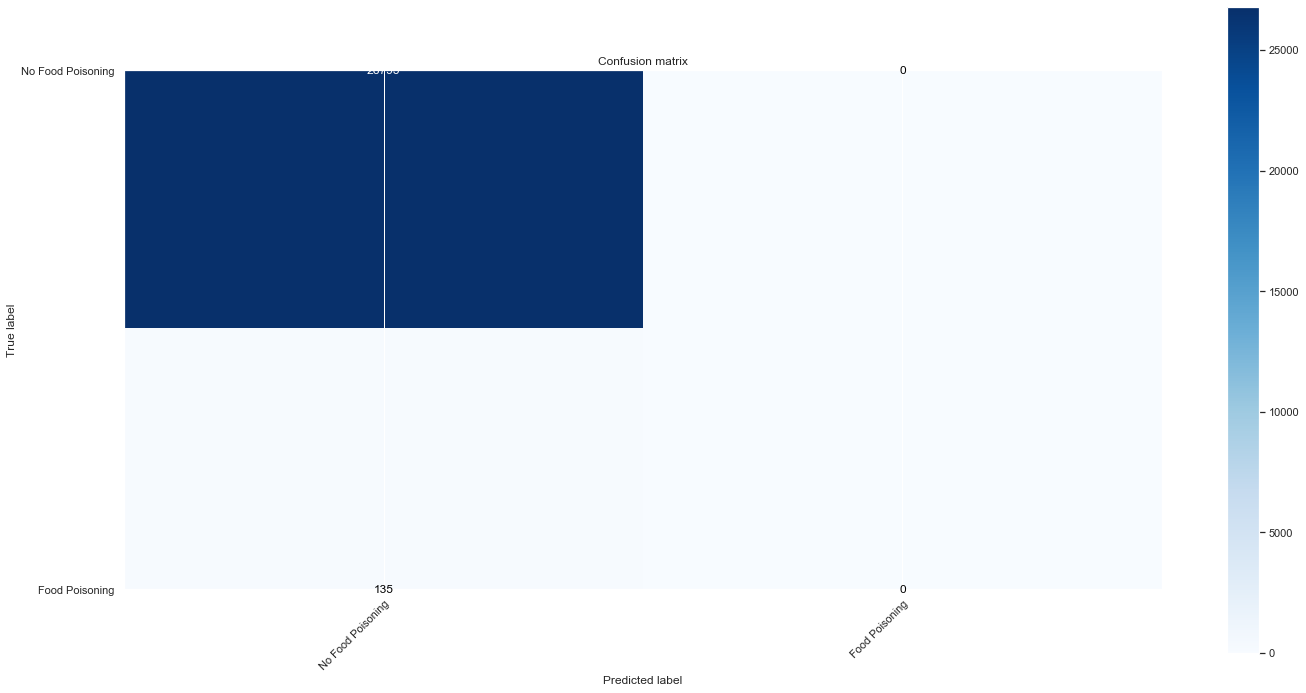

In [61]:
# Confusion matrix for XGB
plot_confusion_matrix(y_test_df1, y_pred_1_XGB, classes=class_names,title='Confusion matrix', figsize=(20,10))

[[26792     3]
 [  135     0]]


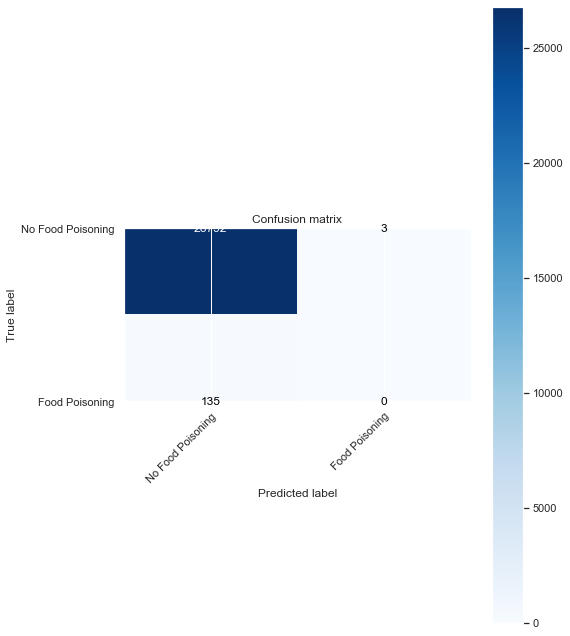

In [23]:
# Confusion matrix for Random Forest
plot_confusion_matrix(y_test_df1, y_pred_1_rf, classes=class_names,title='Confusion matrix', figsize=(8,9))

> Although both models yield a very high accuracy, they are completely unefficient at predicting food poisoning cases. This suggests that the data we have is unbalanced. We decided to plot the class distribution to confirm this hypothesis.

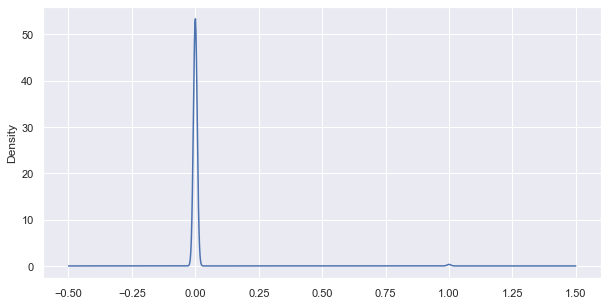

In [24]:
# Plot the density for each class
plt.figure(figsize=(10,5))
df_New['inspection_type_Suspected Food Poisoning'].plot(kind='density', subplots=True, sharex=False)
plt.show()

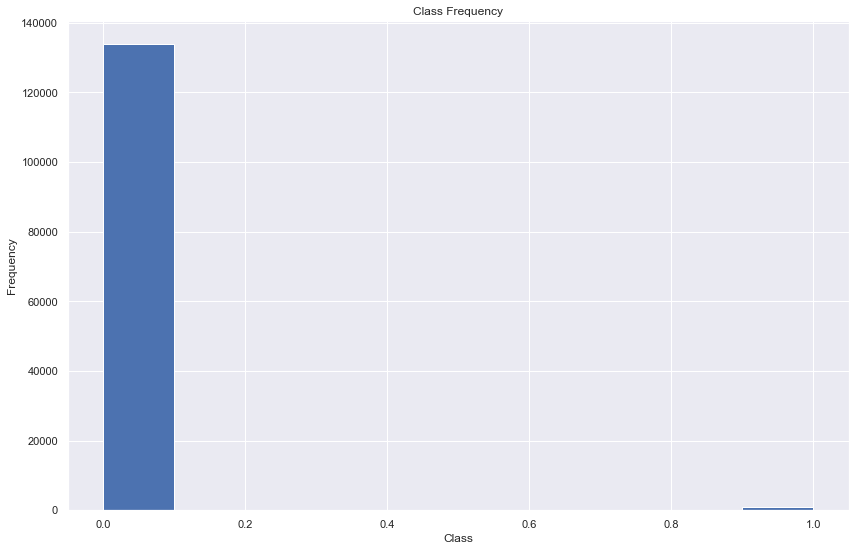

In [25]:
# Plot the class distribution as histograms
plt.figure(figsize=(14,9))
df_New['inspection_type_Suspected Food Poisoning'].hist()
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

> **Conclusions**: Indeed, the class is extremely unbalanced. Hence, accuracy is not a reliable metric for the real performance of tested classifiers here, and yields misleading results if the data set is unbalanced (that is, the numbers of observations in different classes vary greatly, which is pretty obvious by looking at the histogram).

## Training a model suited for unbalanced data

The F1 score often turns to be a better metric when dealing with unbalanced data. Moreover, XGBoost is better equipped for this kind of use. Hence, we will train an XGBoost model that tend to maximise the F1_score rather than the accuracy. 

**1)** First, using the sorted dataset grouped by licence, **data_classified**.

In [26]:
# Drop unnecessary columns from the dataset sorted by time of inspection
df_02 = data_classified.drop(['inspection_id', 'license', 'inspection_date',
                    'inspection_type_Canvass',
                    'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
                    'inspection_type_Complaint Re-Inspection',
                    'inspection_type_Short Form Complaint',
                    'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)
df_02.head(2)

,#1,#10,#11,#12,#13,#14,#15,#16,#17,#18,...,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Suspected Food Poisoning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Make the features and target dataframes and display the features dataframe
target_df_02 = df_02['inspection_type_Suspected Food Poisoning']
features_df_02 = df_02.drop(['inspection_type_Suspected Food Poisoning'], axis = 1)
features_df_02.head(2)

,#1,#10,#11,#12,#13,#14,#15,#16,#17,#18,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Train and test sets for time series dataframes
X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(features_df_02, target_df_02, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

> Additionally, we passed the ratio of the dominant binary class (0) over the minimal class (1) to the 'scale_pos_weight' argument of the XGBClassifier. This enables to put a weight on the dominant class, and obtain better results for unbalanced data.

In [29]:
# Compute the ratio

y_train_OK = y_train_df2[y_train_df2 == 1]
len_OK = len(y_train_OK)

y_train_not_OK = y_train_df2[y_train_df2  == 0]
len_not_OK = len(y_train_not_OK)

ratio_train = float(len_not_OK/len_OK)

In [30]:
# Cross validation to optimize F1 score, test set validation
y_pred_2, XGB_classifier_2 = GBT_classification(X_train_df2, y_train_df2, X_test_df2, y_test_df2, tscv, ratio_train)

Gradient Boosted trees model accuracy score : 0.8690679539546974
Gradient Boosted trees model F1 score : 0.9260626177225769


[[23366  3452]
 [   74    38]]


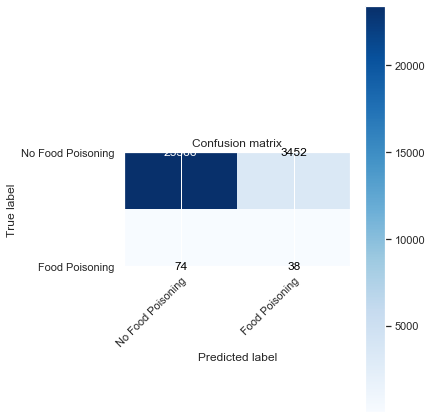

In [31]:
# Confusion matrix 
plot_confusion_matrix(y_test_df2, y_pred_2, classes=class_names,title='Confusion matrix', figsize=(6,6))
plt.savefig('CM_1.png')

> **Observation**: Increase in the number of Food poisoning correctly identified as such (True positives). However, the False Negatives value is greater (True 'Food Poisoning' classified as 'No Food Poisoning'), and this model will most likely fail at classifying correctly cases of food poisoning.

**2)** We decided to try to train our model with the other sorted dataset **df_New**.

In [32]:
# Drop unnecessary columns from the dataset sorted by time of inspection
df_03 = df_New.drop(['inspection_id', 'license', 'inspection_date',
                    'inspection_type_Canvass',
                    'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
                    'inspection_type_Complaint Re-Inspection',
                    'inspection_type_Short Form Complaint',
                    'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)
df_03.head(2)

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Suspected Food Poisoning
134647,134647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134622,134622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Make the features and target dataframes and display the features dataframe
target_df_03 = df_03['inspection_type_Suspected Food Poisoning']
features_df_03 = df_03.drop(['inspection_type_Suspected Food Poisoning'], axis = 1)
features_df_03.head(2)

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
134647,134647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134622,134622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Train and test sets for time series dataframes 
X_train_df3, X_test_df3, y_train_df3, y_test_df3 = train_test_split(features_df_03, target_df_03, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

# Compute the ratio

y_train_OK = y_train_df3[y_train_df3 == 1]
len_OK = len(y_train_OK)

y_train_not_OK = y_train_df3[y_train_df3 == 0]
len_not_OK = len(y_train_not_OK)

ratio_train = float(len_not_OK/len_OK)

In [35]:
# Cross validation to optimize F1 score, test set validation
y_pred_3, XGB_classifier_3 = GBT_classification(X_train_df3, y_train_df3, X_test_df3, y_test_df3, tscv, ratio_train)

Gradient Boosted trees model accuracy score : 0.9726698848867434
Gradient Boosted trees model F1 score : 0.9813295041470217


[[26184   611]
 [  125    10]]


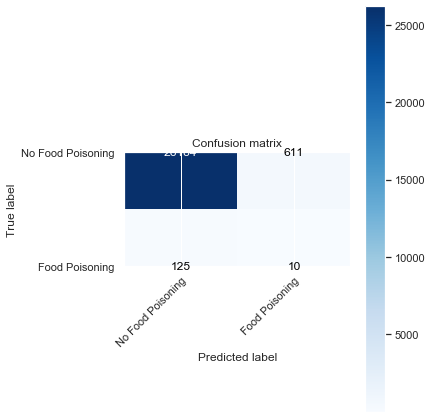

In [36]:
# Confusion matrix 
plot_confusion_matrix(y_test_df3, y_pred_3, classes=class_names,title='Confusion matrix', figsize=(6,6))
plt.savefig('CM_2.png')

> **Observation**: An even higher increase in the number of Food poisoning correctly identified as such (True positives) is observed. However, the False Negatives value is also lower compared with the previous model (True 'Food Poisoning' classified as 'No Food Poisoning'), and this model is more suited for classifying correctly cases of food poisoning, even though we loose some accuracy.

**3)** Dataset with the score value (**df_New_2**).

In [37]:
df_New_2.head(2)

,inspection_id,inspection_date,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,...,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Canvass,inspection_type_Canvass Re-Inspection,inspection_type_Complaint,inspection_type_Complaint Re-Inspection,inspection_type_Short Form Complaint,inspection_type_Suspected Food Poisoning,inspection_type_Suspected Food Poisoning Re-inspection
134647,104236,2010-01-04,NaN,134647,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134622,134239,2010-01-05,NaN,134622,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [49]:
# Drop useless columns from the dataset of interest
df_04 = df_New_2.drop(['inspection_type_Canvass',
       'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
       'inspection_type_Complaint Re-Inspection',
       'inspection_type_Short Form Complaint',
       'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)

del df_04['Unnamed: 0']


# Make the features and target dataframes and display the features dataframe
target_df_04 = df_04['inspection_type_Suspected Food Poisoning']
features_df_04 = df_04.drop(['inspection_type_Suspected Food Poisoning', 'inspection_date', 'inspection_id', 'license'], axis = 1)

# Drop the violations
features_df_04 = features_df_04[features_df_04.columns.drop(list(features_df_04.filter(regex='#')))]
features_df_04.head(2)

,score,risk,results,zip_60601.0,zip_60602.0,zip_60603.0,zip_60604.0,zip_60605.0,zip_60606.0,zip_60607.0,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
134647,NaN,3,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134622,NaN,3,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Train and test sets for time series dataframes 
X_train_df4, X_test_df4, y_train_df4, y_test_df4 = train_test_split(features_df_04, target_df_04, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

# Compute the ratio

y_train_OK = y_train_df4[y_train_df4 == 1]
len_OK = len(y_train_OK)

y_train_not_OK = y_train_df4[y_train_df4  == 0]
len_not_OK = len(y_train_not_OK)

ratio_train = float(len_not_OK/len_OK)

In [51]:
# Cross validation to optimize F1 score, test set validation
y_pred_4, XGB_classifier_4 = GBT_classification(X_train_df4, y_train_df4, X_test_df4, y_test_df4, tscv, ratio_train)

Gradient Boosted trees model accuracy score : 0.5035647976234683
Gradient Boosted trees model F1 score : 0.6650227617064987


[[13468 13327]
 [   42    93]]


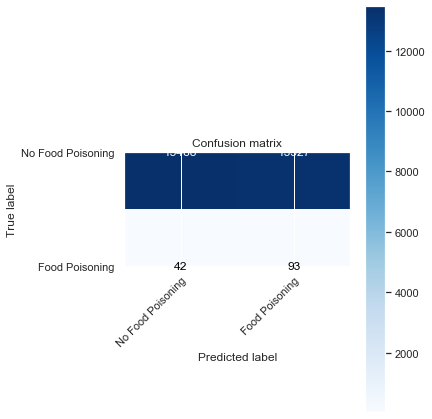

In [52]:
# Plot confusion matrix
plot_confusion_matrix(y_test_df4, y_pred_4, classes=class_names,title='Confusion matrix', figsize=(6,6))

> **Observation**: This model is the best in terms of classifying correctly food poisoning cases, however, is the score really reliable ?

### ROC-curve analysis

A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers. It is obtained by plotting the true positive rate (TPR) against the false positive rate (FPR). Both axes vary between 0 and 1, and the closer the curve is to the upper-left corner, the better is the performance of the model. Moreover, the shape of the ROC curve does not depend on the class distribution, which makes it even better suited for use in our case.

> We plot ROC curves on the same figure for all models, and display the roc-auc score.

roc_auc_score model 1:  0.605283098771614
roc_auc_score model 2:  0.5256356561823999
roc_auc_score model 3:  0.5957599883892103


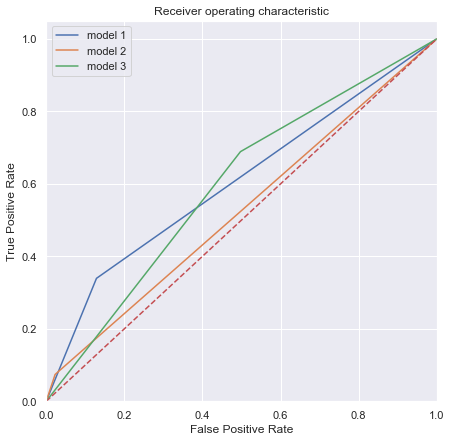

In [53]:
fpr_2, fpr_3, fpr_4 = dict(), dict(), dict()
tpr_2, tpr_3, tpr_4 = dict(), dict(), dict()
roc_auc_2, roc_auc_3, roc_auc_4 = dict(), dict(), dict()
for i in range(2):
    fpr_2[i], tpr_2[i], _ = roc_curve(y_test_df2, y_pred_2)
    roc_auc_2[i] = auc(fpr_2[i], tpr_2[i])
    fpr_3[i], tpr_3[i], _ = roc_curve(y_test_df3, y_pred_3)
    roc_auc_3[i] = auc(fpr_3[i], tpr_3[i])
    fpr_4[i], tpr_4[i], _ = roc_curve(y_test_df4, y_pred_4)
    roc_auc_4[i] = auc(fpr_4[i], tpr_4[i])
        
print('roc_auc_score model 1: ',roc_auc_score(y_test_df2, y_pred_2))
print('roc_auc_score model 2: ',roc_auc_score(y_test_df3, y_pred_3))
print('roc_auc_score model 3: ',roc_auc_score(y_test_df4, y_pred_4))
plt.figure(figsize=(7,7))
plt.plot(fpr_2[1], tpr_2[1], label='model 1')
plt.plot(fpr_3[1], tpr_3[1], label = 'model 2')
plt.plot(fpr_4[1], tpr_4[1], label = 'model 3')
plt.plot ([0.0, 1.0], [0.0, 1.0], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.show()

### Plotting an XGBoost Tree 

For the poster, we decided to highlight this model that we've used extensively, by plotting one of the trees.

> We create a function to do so.

In [54]:
def plot_tree(xgb_model, filename):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    gvz = xgb.to_graphviz(xgb_model)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

> We plot a tree from the third model and another one for the second.

In [55]:
# Model 3
plot_tree(XGB_classifier_4, 'xgboost_test_tree_1.png')

# Model 3
plot_tree(XGB_classifier_4, 'xgboost_test_tree_1.png')

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH